In [1]:
from config import logging
from scipy.stats import norm
import json
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [22]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, KElbow
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.metrics import silhouette_samples,silhouette_score

In [3]:
TDOA_REPORTS = os.getenv('TDOA_REPORTS', 'results/lufthansa24-04/asset_22_floor_2.json')
MILIMETER = int(os.getenv('MILIMETER',  1))

from config import (
    API_BASE,
    API_TOKEN,
    HTTP_TIMEOUT,
    MQTT_HOST,
    MQTT_PASS,
    MQTT_PORT,
    MQTT_USER,
)

In [9]:
messured_data = {}
tags = {}

try:
    f = open(TDOA_REPORTS)
    data = json.load(f)
except OSError as exc:
    logging.warning(f"Failed to open file: {exc}")
    sys.exit(1)

for entrence in data:
    if entrence['asset']['assetId'] is not None:
        uid = entrence['asset']['assetId']
    else:
        # if asset/ assetId doesnt exist save tag with uid
        uid = entrence.pop('id')

    # change the units from meter to millimeter
    if MILIMETER:
        entrence['pos']['x'] = int(entrence['pos']['x']*1000)
        entrence['pos']['y'] = int(entrence['pos']['y']*1000)
        try:
            for node in entrence['tdoadebug']:
                node['x'] = int(node['x']*1000)
                node['y'] = int(node['y']*1000)
                node['z'] = int(node['z']*1000)
        except:
            pass

    if uid not in tags:
        tags[uid] = [entrence]
    else:
        tags[uid].append(entrence)

for uid in tags: 
    tags[uid] = sorted(tags[uid], key=lambda k: k['time']) 

for uid in tags:
    for entrence in tags[uid]:
        if [sub['tdoa'] == 0.0 and sub['uid'] == '01aa2145cae48b16' for sub in entrence['tdoadebug']]:
            for tdoa_message in entrence['tdoadebug']:
                if tdoa_message['tdoa'] != 0:
                    if tdoa_message['uid'] in messured_data:
                        messured_data[tdoa_message['uid']].append(tdoa_message['tdoa'])
                    else:
                        messured_data[tdoa_message['uid']] = [tdoa_message['tdoa']]

In [ ]:
# Code section for testing different kinde of algorithem to find the the number of clusters as well as the filtering the data in seperate clusters.

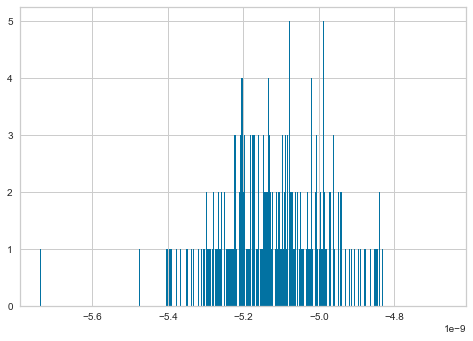

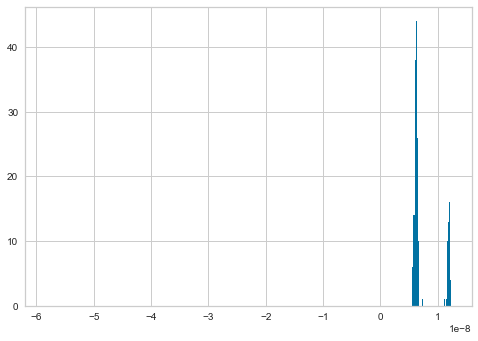

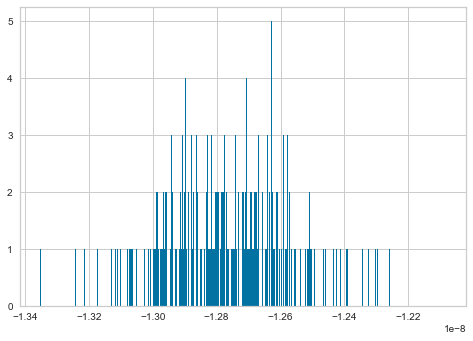

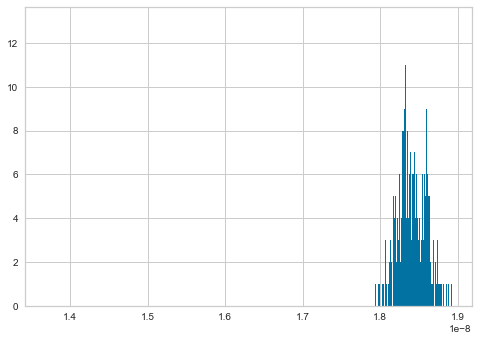

In [24]:
for uid in messured_data:

    fig, ax = plt.subplots()

    n, bins, patches = plt.hist(messured_data[uid], bins = 1000 ,label= uid )

    plt.show()

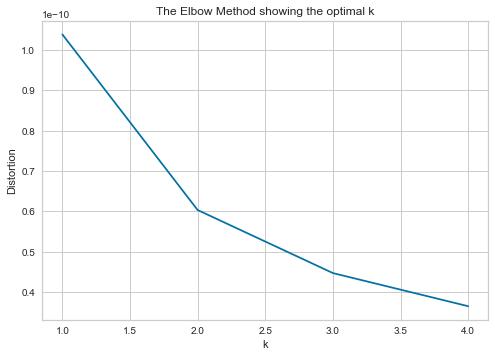

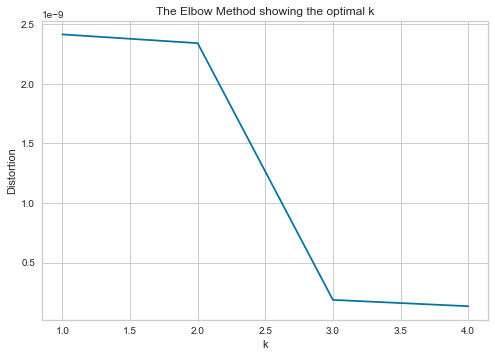

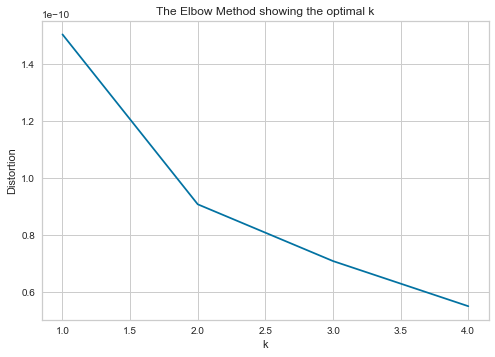

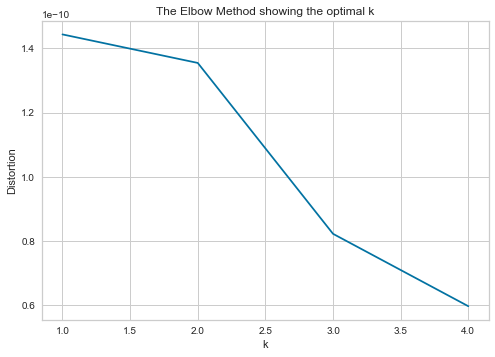

In [27]:
for uid in messured_data:

    data = np.array([messured_data[uid]]).T

    distortions = []
    K = range(1,5)
    
    for k in K:
        kmeanModel = KMeans(n_clusters=k, max_iter=1).fit(data)
        # kmeanModel.fit(test)
        distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [30]:
for uid in messured_data:
    
    data = np.array([messured_data[uid]]).T
    
    # Instantiate the clustering model and visualizer
    model = KMeans()

    visualizer = KElbowVisualizer(
        model, k=(2,4), metric='calinski_harabasz', timings=False, locate_elbow=True
        )
        # if uid == '01aa2145caf203b4':
        #     for value in messured_data[uid]:
        #         if value < 0:
        #             messured_data[uid].remove(value)
        #             # -5.8408445191560077e-08
        #             # 1.1850900483167948e-08
        
    kelbow_visualizer(KMeans(random_state=4), data, k=(1,5))
    visualizer.fit(data)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure  

Error: RuntimeError

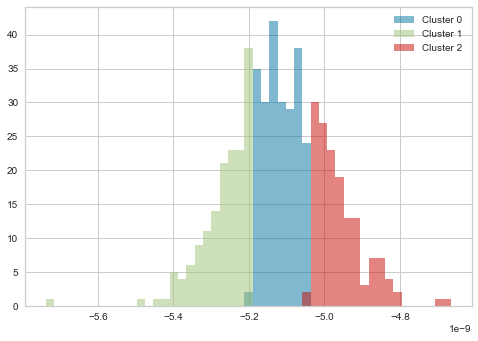

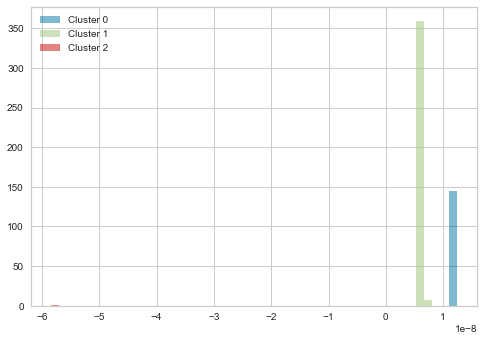

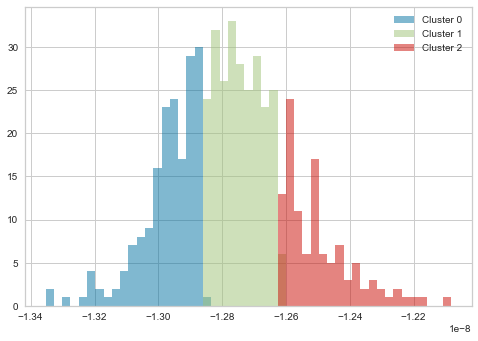

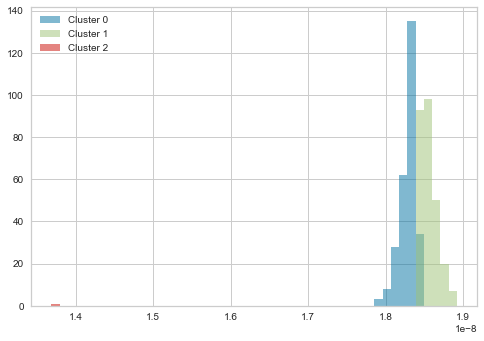

In [37]:
for uid in messured_data:
    
    # # if uid == '01aa2145caf203b4':
    # #     for value in messured_data[uid]:
    # #         if value < 0:
    # #             messured_data[uid].remove(value)
    # #             # -5.8408445191560077e-08
    # #             # 1.1850900483167948e-08

    data = np.array([messured_data[uid]]).T

    cluster_id = KMeans(3).fit_predict(data)
    fig, ax = plt.subplots()
    bins = np.linspace(data.min(), data.max())
    for ii in np.unique(cluster_id):
        subset = data[cluster_id==ii]
        ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
    ax.legend()
    plt.show()

In [ ]:
for uid in messured_data:
    
    # # if uid == '01aa2145caf203b4':
    # #     for value in messured_data[uid]:
    # #         if value < 0:
    # #             messured_data[uid].remove(value)
    # #             # -5.8408445191560077e-08
    # #             # 1.1850900483167948e-08

    data = np.array([messured_data[uid]]).T

    for i,k in enumerate([2,3,4,5]):
        
        fig, ax = plt.subplots(1,2,figsize=(15,5))
        
        # Run the kmeans algorithm
        km = KMeans(n_clusters=k)
        y_predict = km.fit_predict(data)
        centroids  = km.cluster_centers_


In [36]:
# 3 types of methods to find the the rankings of different combinations of cluster.
# 1. silhoutte_score
# 2. calinski harabasz score
# 3. davies bouldin score

In [ ]:
score1 = {}
score2 = {}
score3 = {}

for uid in messured_data:
    
    # # if uid == '01aa2145caf203b4':
    # #     for value in messured_data[uid]:
    # #         if value < 0:
    # #             messured_data[uid].remove(value)
    # #             # -5.8408445191560077e-08
    # #             # 1.1850900483167948e-08

    data = np.array([messured_data[uid]]).T


    score1.update({ uid: [] })
    score2.update({ uid: [] })
    score3.update({ uid: [] })

    for i,k in enumerate([2,3,4,5]):

        fig, ax = plt.subplots(1,2,figsize=(15,5))
        
        # Run the kmeans algorithm
        km = KMeans(n_clusters=k)
        y_predict = km.fit_predict(data)
        centroids  = km.cluster_centers_
        score1[uid].append(silhouette_score(data, km.labels_, metric='euclidean'))
        score2[uid].append(calinski_harabasz_score(data, km.labels_))
        score3[uid].append(davies_bouldin_score(data, km.labels_))